<a href="https://colab.research.google.com/github/S3688570/Cars_Deep_Learning/blob/master/cars_transfer_learning_feat_extract_without_data_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN model of vehicle recognition - Feature extraction without data augmentation

In [1]:
from google.colab import drive, files
drive.mount('/content/gdrive')
gdrive_path = 'gdrive/My\ Drive/Colab\ Notebooks/'
!rsync -ah --progress\
    {gdrive_path}cars_dl/*.zip\
    {gdrive_path}model_weights_final*.h5\
    {gdrive_path}model_struct_final*.json\
    '/content'
!unzip -qo '*.zip'
!rm *.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
sending incremental file list
cars-20191002T050118Z-001.zip
        490.68M 100%   72.09MB/s    0:00:06 (xfr#1, to-chk=2/3)
model_struct_final.json
          5.33K 100%    7.19kB/s    0:00:00 (xfr#2, to-chk=1/3)
model_weights_final.h5
          1.33M 100%    1.12MB/s    0:00:01 (xfr#3, to-chk=0/3)


In [0]:
epochs = 50 #@param {type:"number"}
validation_steps = 32 #@param {type:"number"}
img_height = 128 #@param {type:"integer"}
img_width = 128 #@param {type:"integer"}
batch_size = 32 #@param {type:"number"}


##Example of using a pre-trained model (VGG16) as a classifier

In [3]:
# Load Keras' VGG16 model that was pre-trained against the ImageNet database
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(128, 128, 3))

Using TensorFlow backend.






58892288/58889256 [==============================] - 3s 0us/step








In [4]:
# Summary of Keras' VGG16 model that was pre-trained against the ImageNet database
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

##Number of images in the training, validation and test sets

In [5]:
import os

trainingCarImages = os.listdir('cars/training_set/car/')
print ("Number of Training car images - ",str(len(trainingCarImages)))

trainingCrashImages = os.listdir('cars/training_set/crash/')
print ("Number of Training crash images - ",str(len(trainingCrashImages)))

validCarImages = os.listdir('cars/val_set/car/')
print ("Number of Validation car images - ",str(len(validCarImages)))

validCrashImages = os.listdir('cars/val_set/crash/')
print ("Number of Validation crash images - ",str(len(validCrashImages)))

testCarImages = os.listdir('cars/test_set/car/')
print ("Number of Test car images - ",str(len(testCarImages)))

testCrashImages = os.listdir('cars/test_set/crash/')
print ("Number of Test crash images - ",str(len(testCrashImages)))

train_data_dir = 'cars/training_set/'
validation_data_dir = 'cars/val_set/'
test_data_dir = 'cars/test_set/'
nb_train_samples = trainingCarImages + trainingCrashImages
nb_validation_samples = validCarImages + validCrashImages
nb_test_samples = testCarImages + testCrashImages

Number of Training car images -  1445
Number of Training crash images -  1445
Number of Validation car images -  375
Number of Validation crash images -  372
Number of Test car images -  129
Number of Test crash images -  131


In [0]:
#Method to identify and remove corrupted images
def my_gen(gen):
    while True:
        try:
            imgs, labels = next(gen)
            yield imgs, labels
        except:
            pass

##Extract features using the pre-trained convolutional base

In [7]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 10

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
      target_size=(128, 128),
      batch_size=batch_size,
      class_mode='binary')
  i = 0
  generator = my_gen(generator)
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      # Note that since generators yield data indefinitely in a loop,
      # we must `break` after every image has been seen once.
      break
  return features, labels

train_features, train_labels = extract_features(train_data_dir, 2890)
validation_features, validation_labels = extract_features(validation_data_dir, 747)
test_features, test_labels = extract_features(test_data_dir, 260)

Found 2890 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
Exception ignored in: <generator object my_gen at 0x7f902073fe08>
RuntimeError: generator ignored GeneratorExit


Found 747 images belonging to 2 classes.


Exception ignored in: <generator object my_gen at 0x7f90207c3308>
RuntimeError: generator ignored GeneratorExit


Found 260 images belonging to 2 classes.


Exception ignored in: <generator object my_gen at 0x7f90207d10a0>
RuntimeError: generator ignored GeneratorExit


In [0]:
train_features = np.reshape(train_features, (2890, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (747, 4 * 4 * 512))
test_features = np.reshape(test_features, (260, 4 * 4 * 512))

## Adding a densely-connected classifier on top of the convolutional base

In [9]:
from keras import models          #Make 6 layers of VG16 model tarinable
from keras import layers
from keras import optimizers

model = models.Sequential()
# Fully connected layer
model.add(layers.Dense(output_dim = 128, 
                     activation = 'relu', input_dim = 4 * 4 * 512))                # Dense layer
model.add(layers.Dropout(0.25))                             # Dropout
model.add(layers.Dense(output_dim = 1, 
                     activation = 'sigmoid'))             # Output

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=8192, units=128)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`
  # This is added back by InteractiveShellApp.init_path()


## Summary of extended model

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,048,833
Trainable params: 1,048,833
Non-trainable params: 0
_________________________________________________________________


##Training

In [11]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))



Train on 2890 samples, validate on 747 samples
Epoch 1/30
2890/2890 [==============================] - 1s 435us/step - loss: 0.5582 - acc: 0.7048 - val_loss: 0.4794 - val_acc: 0.7965
Epoch 2/30
2890/2890 [==============================] - 1s 326us/step - loss: 0.4037 - acc: 0.8246 - val_loss: 0.4300 - val_acc: 0.8233
Epoch 3/30
2890/2890 [==============================] - 1s 336us/step - loss: 0.3484 - acc: 0.8581 - val_loss: 0.4056 - val_acc: 0.8313
Epoch 4/30
2890/2890 [==============================] - 1s 340us/step - loss: 0.3157 - acc: 0.8754 - val_loss: 0.4269 - val_acc: 0.8206
Epoch 5/30
2890/2890 [==============================] - 1s 328us/step - loss: 0.2921 - acc: 0.8862 - val_loss: 0.3862 - val_acc: 0.8407
Epoch 6/30
2890/2890 [==============================] - 1s 331us/step - loss: 0.2677 - acc: 0.8986 - val_loss: 0.3899 - val_acc: 0.8394
Epoch 7/30
2890/2890 [==============================] - 1s 332us/step - loss: 0.2537 - acc: 0.9031 - val_loss: 0.3944 - val_acc: 0.8394

In [12]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


## Save neural network structure

In [13]:
from pathlib import Path
import os
transferModelFeatExtract_structure = model.to_json()
f = Path("gdrive/My Drive/Colab Notebooks/transferModelFeatExtract_structure.json")
f.write_text(transferModelFeatExtract_structure)

1285

## Save neural network's trained weights

In [0]:
# Save neural network's trained weights
model.save_weights("gdrive/My Drive/Colab Notebooks/transferModelFeatExtract_weights.h5")
model.save('gdrive/My Drive/Colab Notebooks/transferModelFeatExtract_weights.h5')

## Plot training and validation accuracy per epoch

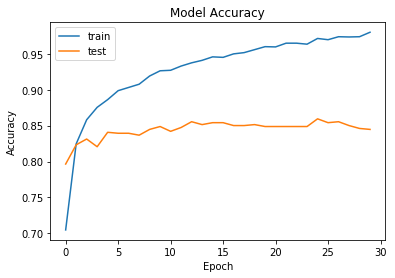

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Plot training and validation loss per epoch

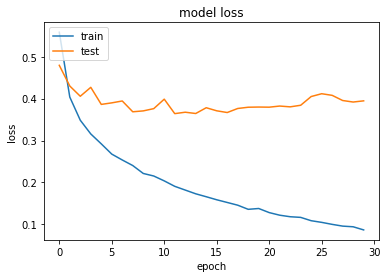

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()